# WILLUMP - Demo

In this notebook, we'll explain how Willump improves the performance of feature computation in ML inference applications.

This version of Willump works specifically on binary classification problems.  It improves performance via _cascades_.  It tries to predict each data input using an approximate model trained on a handful of high-value, low cost features.  For each data input, it returns the approximate prediction if the model's confidence in it is high, but otherwise computes all remaining features and predicts with the original model.  For a more in-depth discussion of Willump, please see [our paper](http://petereliaskraft.net/res/willump.pdf).

We're going to be optimizing a specific application, which predicts whether a user of an online music streaming platform will like a song.  The application was adapted from a top finisher in Kaggle's [KKBox Music Recommendation Challenge](https://www.kaggle.com/c/kkbox-music-recommendation-challenge/overview).

First, let's import dependencies.  Be sure that the printed working directory is the root directory of the Willump-Simple package.

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import sklearn
import time
from lightgbm import LGBMClassifier
import redis
if (os.getcwd().endswith("notebooks")):
    os.chdir("..")
sys.path.insert(0, os.path.abspath("tests/benchmark_scripts"))
print(os.getcwd())
import music_utils
from music_utils import get_features_from_redis

/mnt/c/Users/Peter/Documents/GitHub/Willump-Simple


The application precomputes features for different users and songs and stores them in a database, querying the database when making predictions.  It then makes predictions using a boosted trees model.  In this demo, let's store features in Redis.  

In [2]:
db = redis.StrictRedis(host="localhost")
train_X, test_X, train_y, test_y = music_utils.load_music_dataset(db)

Willump requires applications to be written in a specific format.  First, they must define functions for model training, prediction, confidence, and scoring.  

The training function takes in a vector of training labels and a list of feature vectors and outputs a trained model. 

The prediction function takes in a model and a list of feature vectors and outputs a vector of predictions.

The confidence function takes in a model and a lsit of feature vectors and outputs a vector of the model's confidences in its predictions.

The scoring function takes in vectors of predicted and true labels and outputs a score, where higher scores are better.

In this application, the training function trains a boosted trees model, the prediction and confidence functions use it to make predictions, and the score function computes an AUC score.

In [3]:
def music_train(y, X_list):
    X = pd.concat(X_list, axis=1)
    X = X[[f for f in music_utils.FEATURES if f in X.columns]]
    model = LGBMClassifier(
        n_jobs=1,
        learning_rate=0.1,
        num_leaves=(2 ** 8),
        max_depth=15,
        metric="auc")
    model = model.fit(X, y)
    return model


def music_predict(model, X_list):
    X = pd.concat(X_list, axis=1)
    X = X[[f for f in music_utils.FEATURES if f in X.columns]]
    if len(X) == 0:
        return np.zeros(0, dtype=np.float32)
    else:
        return model.predict(X)


def music_confidence(model, X_list):
    X = pd.concat(X_list, axis=1)
    X = X[[f for f in music_utils.FEATURES if f in X.columns]]
    return model.predict_proba(X)[:, 1]


def music_score(true_y, pred_y):
    fpr, tpr, _ = sklearn.metrics.roc_curve(true_y, pred_y, pos_label=1)
    return sklearn.metrics.auc(fpr, tpr)

The application itself must be writen as a Python function that computes features and then either trains a model or makes predictions.  To make parsing easy, we require that the function be written in [static single assignment form](https://en.wikipedia.org/wiki/Static_single_assignment_form):  each line calls a Python function to compute some feature.  The last line trains a model or makes predictions from these features.

Below is our application, written as a Python function. Each line retrieves a different set of features.  The final line trains a model on all of them.

The decorator attached to this function is the Willump interface.  It tells Willump to train cascades using this pipeline and model functions.  To train cascades, simply execute the decorated function on a training set and labels; Willump will automatically construct cascades and store their parameters in the train_cascades_params dictionary so they can later be used for prediction.

In [4]:
from willump.evaluation.willump_executor import willump_execute

train_cascades_params = {} # The computed parameters will be stored here.

@willump_execute(train_function=music_train,
                 predict_function=music_predict,
                 confidence_function=music_confidence,
                 score_function=music_score,
                 train_cascades_params=train_cascades_params)
def music_train_pipeline(input_X, input_y):
    user_latent_features = get_features_from_redis(
        input_X, column="msno", name="features_uf", db=db)
    song_latent_features = get_features_from_redis(
        input_X, column="song_id", name="features_sf", db=db)
    user_cluster_features = get_features_from_redis(
        input_X, column="cluster_msno_25", name="uc_features", db=db)
    song_cluster_features = get_features_from_redis(
        input_X, column="cluster_song_id_25", name="sc_features", db=db)
    artist_cluster_features = get_features_from_redis(
        input_X, column="cluster_artist_name_25", name="ac_features", db=db)
    user_features = get_features_from_redis(
        input_X, column="msno", name="us_features", db=db)
    song_features = get_features_from_redis(
        input_X, column="song_id", name="ss_features", db=db)
    artist_features = get_features_from_redis(
        input_X, column="artist_name", name="as_features", db=db)
    genre_features = get_features_from_redis(
        input_X, column="genre_max", name="gs_features", db=db)
    city_features = get_features_from_redis(
        input_X, column="city", name="cs_features", db=db)
    ages_features = get_features_from_redis(
        input_X, column="bd", name="ages_features", db=db)
    language_features = get_features_from_redis(
        input_X, column="language", name="ls_features", db=db)
    gender_features = get_features_from_redis(
        input_X, column="gender", name="gender_features", db=db)
    composer_features = get_features_from_redis(
        input_X, column="composer", name="composer_features", db=db)
    lyrs_features = get_features_from_redis(
        input_X, column="lyricist", name="lyrs_features", db=db)
    sns_features = get_features_from_redis(
        input_X, column="source_screen_name", name="sns_features", db=db)
    stabs_features = get_features_from_redis(
        input_X, column="source_system_tab", name="stabs_features", db=db)
    stypes_features = get_features_from_redis(
        input_X, column="source_type", name="stypes_features", db=db)
    regs_features = get_features_from_redis(
        input_X, column="registered_via", name="regs_features", db=db)
    return music_train(input_y,
                       [user_latent_features, song_latent_features, user_cluster_features,
                        song_cluster_features, artist_cluster_features, user_features,
                        song_features, artist_features, genre_features, city_features,
                        ages_features, language_features, gender_features,
                        composer_features,lyrs_features, sns_features, stabs_features,
                        stypes_features, regs_features])

To better explain _how_ Willump works, instead of constructing cascades using the decorator, we will construct them manually, explaining each step of the process.  To construct cascades, we must find a set of high-value, low-cost features from which we can train an approximate model that can make accurate predictions.

To do this, we'll first compute all the features used in the pipeline and measure the cost of each--how long each took to compute.  We find that each feature takes the same amount of time to compute, which makes sense as they're all stored in the same server.

In [5]:
from willump.evaluation import cascades_construct

train_X_features, feature_costs, feature_names = music_utils.compute_features(train_X, db)

Next, we'll measure the importance of each feature: how much value it has to the model.  We measure feature importance using [permutation importance](https://christophm.github.io/interpretable-ml-book/feature-importance.html), a model-agnostic metric.

In [6]:
cascades_train_X, cascades_valid_X, cascades_train_y, cascades_valid_y = \
    cascades_construct.train_test_split(train_X_features, train_y, test_size=0.25, random_state=42)
train_set_full_model = music_train(cascades_train_y, cascades_train_X)

feature_importances = \
    cascades_construct.calculate_feature_importances(train_set_full_model,
                                                     cascades_valid_X, cascades_valid_y,
                                                     music_predict, music_score,
                                                     feature_names)

cascades_construct.pretty_print(feature_importances, feature_costs)

Feature: user_latent_features      Cost:  1.000 Importance:  0.102
Feature: user_cluster_features     Cost:  1.000 Importance:  0.040
Feature: song_cluster_features     Cost:  1.000 Importance:  0.039
Feature: sns_features              Cost:  1.000 Importance:  0.033
Feature: song_latent_features      Cost:  1.000 Importance:  0.023
Feature: stabs_features            Cost:  1.000 Importance:  0.016
Feature: user_features             Cost:  1.000 Importance:  0.015
Feature: artist_cluster_features   Cost:  1.000 Importance:  0.011
Feature: stypes_features           Cost:  1.000 Importance:  0.008
Feature: regs_features             Cost:  1.000 Importance:  0.007
Feature: city_features             Cost:  1.000 Importance:  0.006
Feature: genre_features            Cost:  1.000 Importance:  0.005
Feature: ages_features             Cost:  1.000 Importance:  0.004
Feature: language_features         Cost:  1.000 Importance:  0.002
Feature: artist_features           Cost:  1.000 Importance:  0

Now that we know the cost and importance of each feature, let's construct cascades!  To do this, let's pick a feature cost cutoff; for example, half the total feature cost.  We'll construct cascades from the best set of features whose cost is less than that cutoff, defined as the set with maximum feature importance scores.  This is computable by a simple [knapsack problem](https://en.wikipedia.org/wiki/Knapsack_problem).

In [7]:
total_feature_cost = sum(feature_costs.values())
cost_cutoff = 0.5 * total_feature_cost
selected_indices = cascades_construct.select_features(feature_costs, feature_importances, cost_cutoff)
selected_features = [feature_names[i] for i in selected_indices]

print("Total feature cost: %5.3f  Selected feature cost cutoff: %5.3f" % (total_feature_cost, cost_cutoff))
print("Selected features:")
for feature in selected_features:
    print("\t%s" % feature)

Total feature cost: 19.000  Selected feature cost cutoff: 9.500
Selected features:
	user_latent_features
	song_latent_features
	user_cluster_features
	song_cluster_features
	artist_cluster_features
	user_features
	sns_features
	stabs_features
	stypes_features


We have now selected a set of features!  Let's see how well it does.  To construct cascades, we train an approximate model from those features.  We then predict a held-out validation set with that model to compute a confidence threshold; cascades only return approximate predictions if their confidence is above that threshold.  To estimate how much cascades will improve performance, we can average the cost of computing the selected features with the cost of computing all features, weighted by the fraction of data inputs we expect will be approximated.

In [8]:
threshold, fraction_approximated = \
    cascades_construct.calculate_feature_set_performance(cascades_train_X, cascades_train_y, 
                                                         cascades_valid_X, cascades_valid_y,
                                                         selected_indices,
                                                         music_train, music_predict,
                                                         music_confidence, music_score,
                                                         train_set_full_model)
selected_feature_cost = sum(feature_costs[feature_names[i]] for i in selected_indices)
expected_cost = fraction_approximated * selected_feature_cost + \
    (1 - fraction_approximated) * total_feature_cost

print("Confidence threshold: %5.3f  Percentage of inputs approximated: %5.3f" 
      % (threshold, fraction_approximated))
print("Expected Query Cost = Percent Approximated * Selected Feature Cost +\n" +
      "\t\t      Percent Not Approximated * Total Feature Cost")
print("\t\t    = %5.3f * %5.3f + %5.3f * %5.3f = %5.3f" % 
      (fraction_approximated, selected_feature_cost,
       1 - fraction_approximated, total_feature_cost, expected_cost))
print("Projected speedup: %5.3f" % (total_feature_cost / expected_cost))

Confidence threshold: 0.600  Percentage of inputs approximated: 0.818
Expected Query Cost = Percent Approximated * Selected Feature Cost +
		      Percent Not Approximated * Total Feature Cost
		    = 0.818 * 9.000 + 0.182 * 19.000 = 10.823
Projected speedup: 1.756


As we can see, cascades are expected to improve performance by 1.75x.  That's not nothing, but it's not great either.  Can we do better?   Earlier, we said we would construct cascades from the best set of features whose cost was less than half the total feature cost.  The choice of half was arbitary--we could just as easily have chosen another value.  Let's try with one quarter the total cost!

In [9]:
total_feature_cost = sum(feature_costs.values())
cost_cutoff = 0.25 * total_feature_cost
selected_indices = cascades_construct.select_features(feature_costs, feature_importances, cost_cutoff)
selected_features = [feature_names[i] for i in selected_indices]

print("Total feature cost: %5.3f  Selected feature cost cutoff: %5.3f" % (total_feature_cost, cost_cutoff))
print("Selected features:")
for feature in selected_features:
    print("\t%s" % feature)

threshold, fraction_approximated = \
    cascades_construct.calculate_feature_set_performance(cascades_train_X, cascades_train_y, 
                                                         cascades_valid_X, cascades_valid_y,
                                                         selected_indices,
                                                         music_train, music_predict,
                                                         music_confidence, music_score,
                                                         train_set_full_model)
selected_feature_cost = sum(feature_costs[feature_names[i]] for i in selected_indices)
expected_cost = fraction_approximated * selected_feature_cost + \
(1 - fraction_approximated) * total_feature_cost
print("Confidence threshold: %5.3f  Percentage of inputs approximated: %5.3f" 
      % (threshold, fraction_approximated))
print("Expected Query Cost = Percent Approximated * Selected Feature Cost +\n" +
      "\t\t      Percent Not Approximated * Total Feature Cost")
print("\t\t    = %5.3f * %5.3f + %5.3f * %5.3f = %5.3f" % 
      (fraction_approximated, selected_feature_cost,
       1 - fraction_approximated, total_feature_cost, expected_cost))
print("Projected speedup: %5.3f" % (total_feature_cost / expected_cost))

Total feature cost: 19.000  Selected feature cost cutoff: 4.750
Selected features:
	user_latent_features
	user_cluster_features
	song_cluster_features
	sns_features
Confidence threshold: 0.600  Percentage of inputs approximated: 0.835
Expected Query Cost = Percent Approximated * Selected Feature Cost +
		      Percent Not Approximated * Total Feature Cost
		    = 0.835 * 4.000 + 0.165 * 19.000 = 6.480
Projected speedup: 2.932


We're doing better!  We're computing fewer features when using the approximate model, but still approximating most data inputs, so we're seeing a much larger expected performance improvement of almost 3x.  In practice, Willump will experiment with several different cost cutoffs and choose the one that maximizes projected performance improvement.

Now, we construct cascades from the features we selected above, training approximate and full models on the entire training set and storing them in a parameter dictionary.

In [10]:
cascades_params = {}
cascades_params["selected_feature_indices"] = selected_indices
cascades_params["cascade_threshold"] = threshold
full_model = music_train(train_y, train_X_features)
cascades_params["full_model"] = full_model
approximate_model = music_train(train_y, [train_X_features[i] for i in selected_indices])
cascades_params["approximate_model"] = approximate_model

Now, let's evaluate how well cascades perform in practice.  Here's the prediction pipeline for this application.  Let's run the pipeline without cascades to see how well it does.

In [11]:
def music_eval_pipeline(input_X, model):
    user_latent_features = get_features_from_redis(
        input_X, column="msno", name="features_uf", db=db)
    song_latent_features = get_features_from_redis(
        input_X, column="song_id", name="features_sf", db=db)
    user_cluster_features = get_features_from_redis(
        input_X, column="cluster_msno_25", name="uc_features", db=db)
    song_cluster_features = get_features_from_redis(
        input_X, column="cluster_song_id_25", name="sc_features", db=db)
    artist_cluster_features = get_features_from_redis(
        input_X, column="cluster_artist_name_25", name="ac_features", db=db)
    user_features = get_features_from_redis(
        input_X, column="msno", name="us_features", db=db)
    song_features = get_features_from_redis(
        input_X, column="song_id", name="ss_features", db=db)
    artist_features = get_features_from_redis(
        input_X, column="artist_name", name="as_features", db=db)
    genre_features = get_features_from_redis(
        input_X, column="genre_max", name="gs_features", db=db)
    city_features = get_features_from_redis(
        input_X, column="city", name="cs_features", db=db)
    ages_features = get_features_from_redis(
        input_X, column="bd", name="ages_features", db=db)
    language_features = get_features_from_redis(
        input_X, column="language", name="ls_features", db=db)
    gender_features = get_features_from_redis(
        input_X, column="gender", name="gender_features", db=db)
    composer_features = get_features_from_redis(
        input_X, column="composer", name="composer_features", db=db)
    lyrs_features = get_features_from_redis(
        input_X, column="lyricist", name="lyrs_features", db=db)
    sns_features = get_features_from_redis(
        input_X, column="source_screen_name", name="sns_features", db=db)
    stabs_features = get_features_from_redis(
        input_X, column="source_system_tab", name="stabs_features", db=db)
    stypes_features = get_features_from_redis(
        input_X, column="source_type", name="stypes_features", db=db)
    regs_features = get_features_from_redis(
        input_X, column="registered_via", name="regs_features", db=db)
    return music_predict(model,
                       [user_latent_features, song_latent_features, user_cluster_features,
                        song_cluster_features, artist_cluster_features, user_features,
                        song_features, artist_features, genre_features, city_features,
                        ages_features, language_features, gender_features,
                        composer_features,lyrs_features, sns_features, stabs_features,
                        stypes_features, regs_features])

time_start = time.time()
preds = music_eval_pipeline(test_X[:2000], full_model)
unopt_time_elapsed = time.time() - time_start
print("Elapsed Time %fs" % unopt_time_elapsed)

print("AUC Score: %f" % music_score(preds, test_y[:2000]))

Elapsed Time 9.090646s
AUC Score: 0.749237


Now, let's use cascades!  Like before, the decorator tells Willump what to do--in this case, optimize the pipeline using the cascades parameters we determined earlier.  We now run the optimized pipeline.

In [12]:
@willump_execute(predict_function=music_predict,
                 confidence_function=music_confidence,
                 predict_cascades_params=cascades_params)
def music_eval_pipeline(input_X, model):
    user_latent_features = get_features_from_redis(
        input_X, column="msno", name="features_uf", db=db)
    song_latent_features = get_features_from_redis(
        input_X, column="song_id", name="features_sf", db=db)
    user_cluster_features = get_features_from_redis(
        input_X, column="cluster_msno_25", name="uc_features", db=db)
    song_cluster_features = get_features_from_redis(
        input_X, column="cluster_song_id_25", name="sc_features", db=db)
    artist_cluster_features = get_features_from_redis(
        input_X, column="cluster_artist_name_25", name="ac_features", db=db)
    user_features = get_features_from_redis(
        input_X, column="msno", name="us_features", db=db)
    song_features = get_features_from_redis(
        input_X, column="song_id", name="ss_features", db=db)
    artist_features = get_features_from_redis(
        input_X, column="artist_name", name="as_features", db=db)
    genre_features = get_features_from_redis(
        input_X, column="genre_max", name="gs_features", db=db)
    city_features = get_features_from_redis(
        input_X, column="city", name="cs_features", db=db)
    ages_features = get_features_from_redis(
        input_X, column="bd", name="ages_features", db=db)
    language_features = get_features_from_redis(
        input_X, column="language", name="ls_features", db=db)
    gender_features = get_features_from_redis(
        input_X, column="gender", name="gender_features", db=db)
    composer_features = get_features_from_redis(
        input_X, column="composer", name="composer_features", db=db)
    lyrs_features = get_features_from_redis(
        input_X, column="lyricist", name="lyrs_features", db=db)
    sns_features = get_features_from_redis(
        input_X, column="source_screen_name", name="sns_features", db=db)
    stabs_features = get_features_from_redis(
        input_X, column="source_system_tab", name="stabs_features", db=db)
    stypes_features = get_features_from_redis(
        input_X, column="source_type", name="stypes_features", db=db)
    regs_features = get_features_from_redis(
        input_X, column="registered_via", name="regs_features", db=db)
    return music_predict(model,
                       [user_latent_features, song_latent_features, user_cluster_features,
                        song_cluster_features, artist_cluster_features, user_features,
                        song_features, artist_features, genre_features, city_features,
                        ages_features, language_features, gender_features,
                        composer_features,lyrs_features, sns_features, stabs_features,
                        stypes_features, regs_features])

music_eval_pipeline(test_X.iloc[:100], full_model)
music_eval_pipeline(test_X.iloc[:100], full_model)
time_start = time.time()
preds = music_eval_pipeline(test_X[:2000], full_model)
cascades_time_elapsed = time.time() - time_start
print("Elapsed Time %fs" % cascades_time_elapsed)

print("AUC Score: %f" % music_score(preds, test_y[:2000]))

Elapsed Time 3.380023s
AUC Score: 0.750532


Much faster, and with no accuracy loss!  To visualize the improvement, we can plot the throughputs:

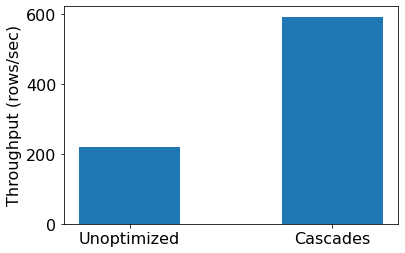

In [13]:
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
fig, axes = plt.subplots(figsize=(6, 4), ncols=1, nrows=1,
                         sharex=False, sharey=False)
x = np.arange(2)
width = 0.5  # the width of the bars

bars = axes.bar(x, [2000 / unopt_time_elapsed, 2000 / cascades_time_elapsed], width)
axes.set(xlabel='', ylabel='Throughput (rows/sec)')
axes.set_xticks(x)
axes.set_xticklabels(["Unoptimized", "Cascades"])
plt.show()

Not bad!  A ~2.8x performance improvement.  This process is fully automatic and model-agnostic once you write your application in the correct format, so you can try it for yourself and see similar gains!